In [3]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown


In [69]:
# initialize the OpenAI client
import os
from google.generativeai import GenerativeModel, configure
from helper import get_gemini_api_key

# Load Gemini API access token from environment variable
GEMINI_API_KEY = get_gemini_api_key()

configure(api_key=GEMINI_API_KEY)

# Initialize the Gemini model client
MODEL = "gemini-2.0-flash-exp"
client = GenerativeModel(MODEL)

In [18]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [10]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [25]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.generate_content(formatted_prompt)
    
    # For Gemini, the response object has a 'text' attribute for the generated content
    return response.text

In [26]:
# code for tool 1
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

In [27]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

In [28]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [30]:
# code for tool 2
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.generate_content(formatted_prompt)
    analysis = response.text
    return analysis if analysis else "No analysis could be generated"

In [31]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Okay, let's analyze the provided sales data snippet. Here's a breakdown of the trends and potential insights:

**Overall Observations:**

*   **Single Store & Day:** The data represents sales from a single store (Store Number 1320) on a single day (2021-11-01).  This limits the ability to identify broader trends but allows focusing on product performance within that context.
*   **Variety of Products:** A good range of products are sold, represented by different SKU codes and product class codes.
*   **Low Volume:** Quantities sold are generally low. Most transactions are for 1-3 units.

**Trends and Potential Insights:**

1.  **Product Class Performance:**

    *   To determine which product class performs best, calculate total quantity sold and total sales value for each `Product_Class_Code`. You could then rank them to understand which categories generate the most revenue and volume.  For instance:
        *   `Product_Class_Code` 22800 seems to be relatively popular with a few sale

In [32]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [33]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [34]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    # Use Gemini SDK to generate and parse the response
    response = client.generate_content(formatted_prompt)
    try:
        # Gemini returns the response as text, so we need to parse it into the VisualizationConfig
        # Try to parse as JSON first, fallback to Pydantic parsing if needed
        import json
        content_dict = json.loads(response.text)
        config = VisualizationConfig(**content_dict)
        return {
            "chart_type": config.chart_type,
            "x_axis": config.x_axis,
            "y_axis": config.y_axis,
            "title": config.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [35]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [36]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    # Use Gemini SDK to generate the code for the chart
    response = client.generate_content(formatted_prompt)
    code = response.text
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [37]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

In [38]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
import io

data = """
    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-

<string>:39: SyntaxWarning: invalid escape sequence '\s'
Matplotlib is building the font cache; this may take a moment.


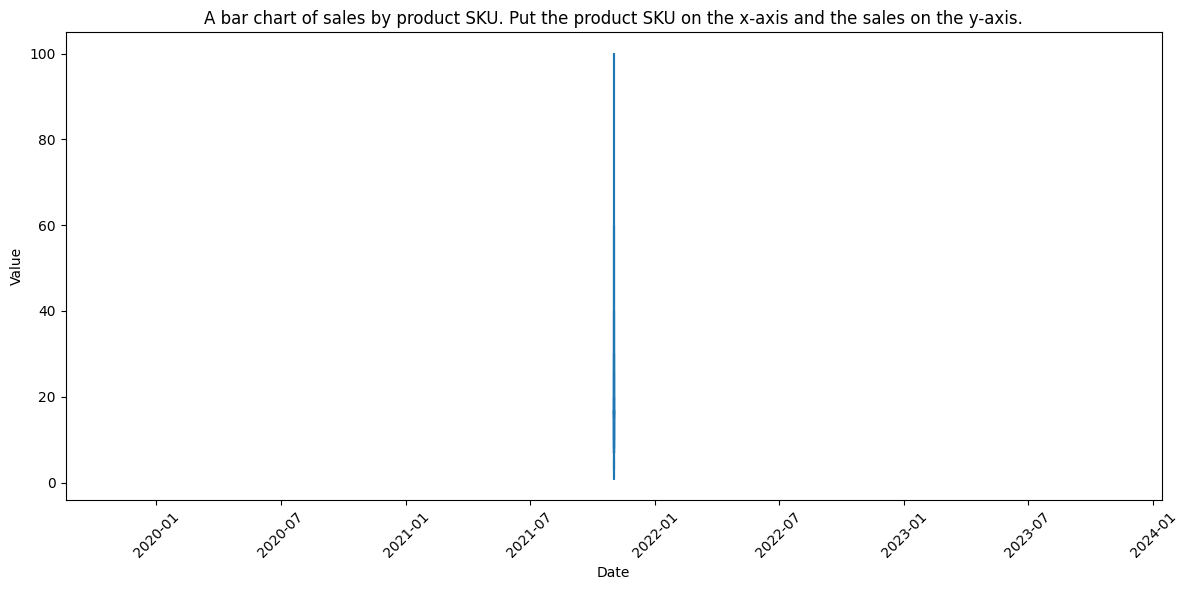

In [41]:
exec(code)

In [42]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

In [43]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [44]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [66]:
import json

def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Extract system prompt for Gemini model initialization
    system_instruction = SYSTEM_PROMPT
    if any(isinstance(message, dict) and message.get("role") == "system" for message in messages):
        system_instruction = next(msg["content"] for msg in messages if msg.get("role") == "system")
        # Remove system message from messages as it's handled separately in Gemini
        messages = [msg for msg in messages if msg.get("role") != "system"]
    
    # Convert OpenAI tools to Gemini format
    def convert_tools_to_gemini(openai_tools):
        if not openai_tools:
            return None
            
        gemini_tools = []
        for tool in openai_tools:
            if tool.get("type") == "function" and "function" in tool:
                func = tool["function"]
                gemini_func = {
                    "name": func["name"],
                    "description": func.get("description", ""),
                }
                
                # Convert parameters, removing 'type' at root level but keeping nested structure
                if "parameters" in func:
                    params = func["parameters"].copy()
                    # Remove the top-level 'type' field that Gemini doesn't want
                    if "type" in params:
                        del params["type"]
                    gemini_func["parameters"] = params
                
                gemini_tools.append(gemini_func)
        
        return gemini_tools if gemini_tools else None
    
    # Convert tools
    gemini_tools = convert_tools_to_gemini(tools)
    
    # Create model with system instruction
    model = GenerativeModel(
        model_name=MODEL,
        system_instruction=system_instruction
    )

    while True:
        print("Making router call to Gemini")

        # Convert messages to Gemini format
        gemini_messages = []
        for msg in messages:
            if msg["role"] == "user":
                gemini_messages.append({"role": "user", "parts": [msg["content"]]})
            elif msg["role"] == "assistant":
                gemini_messages.append({"role": "model", "parts": [msg["content"]]})
            elif msg["role"] == "tool":
                # Tool responses in Gemini format
                gemini_messages.append({
                    "role": "function", 
                    "parts": [{
                        "function_response": {
                            "name": msg.get("name", "unknown"),
                            "response": msg["content"]
                        }
                    }]
                })

        # Start chat and send message
        chat = model.start_chat(history=gemini_messages[:-1] if len(gemini_messages) > 1 else [])
        
        try:
            if gemini_messages:
                latest_msg = gemini_messages[-1]
                if latest_msg["role"] == "user":
                    response = chat.send_message(latest_msg["parts"][0], tools=gemini_tools)
                else:
                    response = chat.send_message("Continue", tools=gemini_tools)
            else:
                response = chat.send_message("Hello", tools=gemini_tools)
        except Exception as e:
            print(f"Error with tools: {e}")
            # Fallback: try without tools
            if gemini_messages:
                latest_msg = gemini_messages[-1]
                if latest_msg["role"] == "user":
                    response = chat.send_message(latest_msg["parts"][0])
                else:
                    response = chat.send_message("Continue")
            else:
                response = chat.send_message("Hello")

        # Extract response content and tool calls
        response_text = response.text if hasattr(response, 'text') else ""
        
        # Add assistant response to messages
        messages.append({
            "role": "assistant",
            "content": response_text
        })

        # Check for function calls in response parts
        function_calls = []
        print(f"Response parts: {len(response.parts) if hasattr(response, 'parts') else 'No parts'}")
        for part in response.parts:
            print(f"Part type: {type(part)}, has function_call: {hasattr(part, 'function_call')}")
            if hasattr(part, 'function_call'):
                fc = part.function_call
                print(f"Function call name: '{fc.name}', args: {fc.args}")
                
                # Skip empty function calls
                if not fc.name:
                    print("Skipping empty function call")
                    continue
                    
                function_calls.append(fc)

        print("Received response with tool calls:", bool(function_calls))

        # If the model decides to call function(s), call handle_tool_calls
        if function_calls:
            print("Processing tool calls")
            
            # Convert Gemini function calls to tool_calls format
            tool_calls = []
            for i, fc in enumerate(function_calls):
                # Handle function arguments safely
                args_dict = {}
                if hasattr(fc, 'args') and fc.args is not None:
                    try:
                        # Convert Gemini args to dict
                        if hasattr(fc.args, 'items'):
                            args_dict = dict(fc.args.items())
                        else:
                            args_dict = dict(fc.args)
                    except (TypeError, ValueError, AttributeError) as e:
                        print(f"Error converting args: {e}")
                        args_dict = {}
                
                # Validate function name exists in tool_implementations
                if fc.name not in tool_implementations:
                    print(f"Warning: Function '{fc.name}' not found in tool_implementations")
                    print(f"Available functions: {list(tool_implementations.keys())}")
                    continue
                
                # Create a proper tool call object
                tool_call = type('ToolCall', (), {
                    'id': f"call_{i}",
                    'type': "function",
                    'function': type('Function', (), {
                        'name': fc.name,
                        'arguments': json.dumps(args_dict)
                    })()
                })()
                tool_calls.append(tool_call)
            
            # Only proceed if we have valid tool calls
            if tool_calls:
                # Update the last message to include tool calls (for compatibility)
                messages[-1]["tool_calls"] = [{
                    "id": tc.id,
                    "type": tc.type,
                    "function": {
                        "name": tc.function.name,
                        "arguments": tc.function.arguments
                    }
                } for tc in tool_calls]
                
                messages = handle_tool_calls(tool_calls, messages)
            else:
                print("No valid tool calls found, returning response")
                return response_text
        else:
            print("No tool calls, returning final response")
            return response_text

In [67]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to Gemini
Error with tools: 'string'
Response parts: 1
Part type: <class 'google.ai.generativelanguage_v1beta.types.content.Part'>, has function_call: True
Function call name: '', args: None
Skipping empty function call
Received response with tool calls: False
No tool calls, returning final response


In [68]:
print(result)
# you can also print a formatted version of the result
# Markdown(result)

```python
import pandas as pd
import plotly.express as px

def analyze_store_sales(df):
    """
    Analyzes and visualizes store sales for November 2021.

    Args:
        df (pd.DataFrame): DataFrame containing store sales data with columns
                           like 'store_id', 'date', and 'sales'.  'date'
                           must be in datetime format.
    """

    # Filter data for November 2021
    df['date'] = pd.to_datetime(df['date'])
    nov_2021_data = df[(df['date'].dt.year == 2021) & (df['date'].dt.month == 11)]

    if nov_2021_data.empty:
        print("No data available for November 2021.")
        return

    # Aggregate sales by store
    store_sales = nov_2021_data.groupby('store_id')['sales'].sum().reset_index()

    # Create bar chart using Plotly
    fig = px.bar(store_sales, x='store_id', y='sales',
                 title='Total Sales by Store in November 2021',
                 labels={'store_id': 'Store ID', 'sales': 'Total Sales'})
    fig.show()
